# Two dimensional FDTD code for plasmonics

In [86]:
"""2D FDTD with YEE-Algorithmus: leapfrog and staggered grid according to 
    Taflove's book
    - in vacuum with Debye material
    - BC: PEC and PML
    - TE-mode

Richard Ciesielski
"""
%load_ext autoreload
%autoreload 2

from __future__ import division     # 1/2 = .5
import numpy
import pylab
%matplotlib inline

# Simulation libraries:
from yee_lib_0_4 import *
from yee_excitations_0_4 import *
from yee_objects_0_4 import *
from yee_plot_0_4 import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up the simulation

In [83]:
# create a mesh:
lengthx = 15.
lengthy = 10.
Nx = 301                            # number of nodes for the E-field
dx = lengthx / (Nx - 1)
Ny =  int(lengthy / dx + 1)
lengthy = (Ny - 1) * dx             # adjust the length

# produce a staggered grid with NxN nodes:
grid = staggered_grid_2D(lengthx, lengthy, Nx, Ny,  Eps0=1, Mu0=1) 

# add PMLs:
grid.addPML(1.5, "right", 11., "full")
grid.addPML(1.5, "left", 11., "full")
grid.addPML(1.5, "up", 11.)
grid.addPML(1.5, "down", 11.)

# add scatterer:
wp = 3
addCircle(grid, 
    x=10, y=lengthy / 2., R=1., wj=0, wp=wp, gamma=1,  sigma=20)

print "Plasma frequency: ", wp

# for later calculations:
dummy_grid = staggered_grid_2D(lengthx, lengthy, Nx, Ny, Eps0=1, Mu0=1)

# add excitation:
excitations = []
excitations.append(testpulse_x_Exc(x=4, H=-1, sigma=1, rc=2))

dt = grid.dt

Plasma frequency:  3


## Executing the simulation

In [84]:
grid.updateConstants()              # absolutely necessary
t, t_end = 0, 15.                   # duration of the simulation
i = 0
cycles = int((t_end - t) / dt)      # total number of cycles

print "number of nodes :",Nx, "x", Ny,"=", Nx*Ny, \
        "\t time step :",dt,  "\t cycles :", cycles

# observation of numerical divergences in Ex,Ey,Hz:
bookkeeping = numpy.zeros((2,cycles))
Ex_w = numpy.zeros(grid.Ex.shape, dtype=complex)
Ey_w = numpy.zeros(grid.Ey.shape, dtype=complex)
Hz_w = numpy.zeros(grid.Hz.shape, dtype=complex)
w_probe = wp /2

for i in range(cycles):             # main loop
    grid.oEx, grid.oEy, grid.oJx, grid.oJy, \
        grid.Ex, grid.Ey, grid.Jx, grid.Jy, grid.Hz = \
            CalculationStep(grid, dummy_grid, t, excitations)
    
    # print progress:
    if cycles > 20:
        if i % int(cycles / 5) == 0: print "simulation time left: ", t_end - t
    
    # calculate the actual absolute value of the Poynting vector:
    S = numpy.sqrt((grid.Ey* grid.Hz[:, :-1])**2 + 
                                 (grid.Ex[:-1, :-1]  * grid.Hz[:, :-1])**2)
    
    # keep track of the convergence
    bookkeeping[0,i] = numpy.sum(S)
    bookkeeping[1,i] = S[int(Ny/2), int(Nx/2)]
    
    # calculate the Fourier transform
    Ex_w+= numpy.exp(1j * t * w_probe) * grid.Ex
    Ey_w+= numpy.exp(1j * t * w_probe) * grid.Ey
    Hz_w+= numpy.exp(1j * t * w_probe) * grid.Hz

    t = t + dt
    i = i + 1
    

number of nodes : 301 x 201 = 60501 	 time step : 0.035 	 cycles : 428
simulation time left:  15.0
simulation time left:  12.025
simulation time left:  9.05
simulation time left:  6.075
simulation time left:  3.1
simulation time left:  0.125


## Postprocessing and Plotting

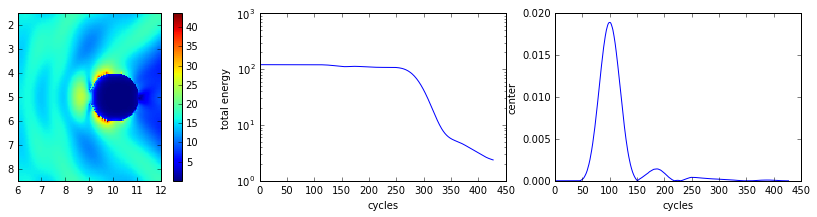

In [85]:
S_w = numpy.sqrt((Ey_w * Hz_w[:, :-1])**2 + 
                                 (Ex_w[:-1, :-1]  * Hz_w[:, :-1])**2)
pylab.figure(figsize=(15,3))
pylab.subplot(131)
#pylab.imshow(abs(S_w))
plot_matrix(abs(S_w), grid, 0, xlim=(6,12))
pylab.colorbar()
pylab.subplot(132)
pylab.semilogy(bookkeeping[0])
pylab.xlabel('cycles')
pylab.ylabel('total energy')
pylab.subplot(133)
pylab.plot(bookkeeping[1])
pylab.xlabel('cycles')
pylab.ylabel('center')

In [53]:
numpy.sum(S)

120.5545219150856

In [72]:
(2*pi*3e-1/w_probe)

1.2566370614359172

In [5]:
xlim[0]=2


In [6]:
xlim.to_list

AttributeError: 'list' object has no attribute 'to_list'